# Nuestras Caras

Este código implementa una técnica de reconocimiento facial conocida como "Eigenfaces". 

La idea básica detrás de Eigenfaces es representar las caras de un conjunto de datos de entrenamiento en un espacio de características de dimensionalidad reducida utilizando el análisis de componentes principales (PCA). 

Luego, las nuevas caras se proyectan en este espacio de características y se comparan con las caras de entrenamiento para reconocerlas.

DEPENDENCIAS NECESARIAS:

Previo a ejecutar la notebook deben ser instaladas las siguientes dependencias:
* pip install opencv-python
* pip install pandas
* pip install matplotlib
* pip install scikit-learn

In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from photo_30x30 import cortar_imagenes
from pixels import intensidad_pixels

In [8]:
#********************************************************************************************************************
#                    CORTE DE LAS FOTOS Y CAMBIO DE ESCALA DE GRISES MEDIANTE PHOTO_30X30.PY
#********************************************************************************************************************
# Definimos donde se encuentran las fotos crudas y donde iran las grises 30x30
#current_directory = os.getcwd()
folder_name_raw = "input"
folder_name_output = "output"

# current_directory
# os.chdir(os.path.join(current_directory, "NuestrasCaras"))


# Cortar las fotos y cambiar a escala de grises
cortar_imagenes(folder_name_raw, folder_name_output)


In [9]:
#********************************************************************************************************************
#                    OBTENCION DE LOS VALORES DE LOS PIXELES DE LAS FOTOS MEDIANTE PIXELS.PY
#********************************************************************************************************************
# Guardo la info de las fotos en un dataframe
folder_path_output = os.path.join(os.getcwd(), folder_name_output)
data_fotos = intensidad_pixels(folder_path_output)

# Get the file names
file_names = data_fotos.iloc[:, 0]

# Tomo los nombres de cada persona
people_names = [name.split("-")[0] for name in file_names]

# Get the greyscale values
greyscale_values = data_fotos.iloc[:, 1:].values

In [12]:
# Dimensiones del array
people_names = np.array(people_names)
people_names.shape

greyscale_values = np.array(greyscale_values)
greyscale_values.shape


(196, 900)

Text(0.5, 1.0, 'Cara Promedio')

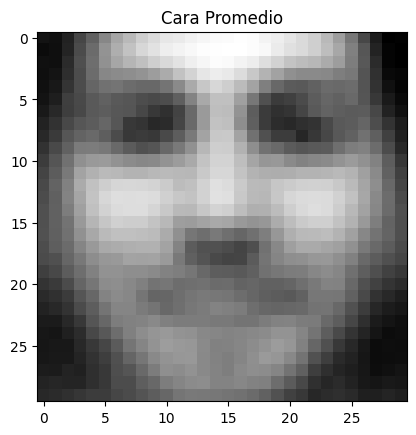

In [13]:
# obtiene y mustra la cara promedio
cara_promedio = np.mean(greyscale_values, axis=0)
cara_promedio.shape
plt.imshow(cara_promedio.reshape(30,30),cmap="gray")
plt.title('Cara Promedio')

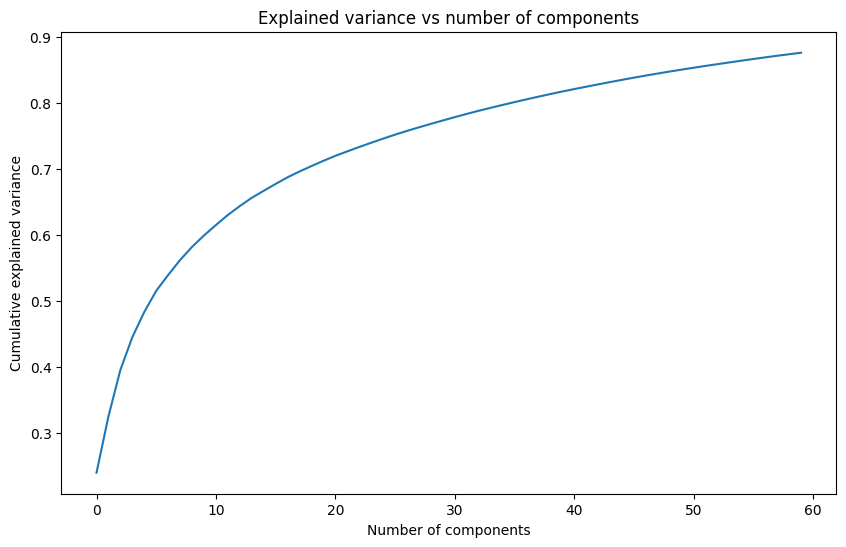

In [18]:
#********************************************************************************************************************
#                    PCA
#********************************************************************************************************************
# Se aplica PCA a las imagenes
# IMPORTANTE! al aumentar el nro de componentes tambien aumenta la precision en la comparacion de imagenes para la clasificacion al final de la notebook!
# Tiene sentido porque aumento el porcentaje de variabilidad explicada por las componentes, acercandome mas a la realidad
n_pca = 60
pca = PCA(n_components=n_pca).fit(greyscale_values)

eigenfaces = pca.components_
varianza_explicada = pca.explained_variance_ratio_

# plot explained variance (grafico continuo)
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(varianza_explicada))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('Explained variance vs number of components')
plt.show()


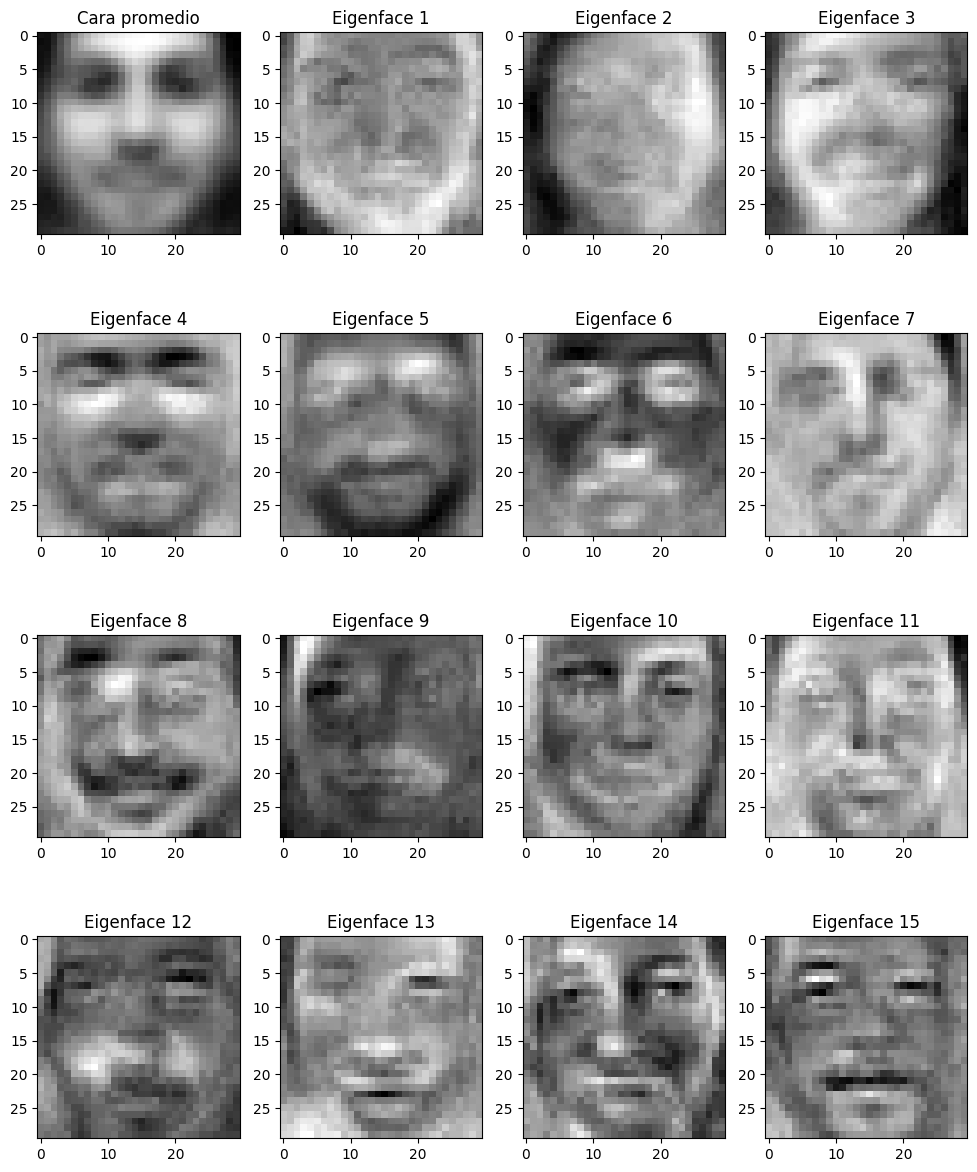

In [19]:
#********************************************************************************************************************
#                    GRAFICO DE LAS PRIMERAS 15 EIGENFACES
#********************************************************************************************************************

fig, ax = plt.subplots(4, 4, figsize=(12, 15))

ax[0, 0].imshow(cara_promedio.reshape(30,30), cmap="gray")
ax[0, 0].set_title("Cara promedio")

for i in range(0,15): # primeras 15 pca
    ax[(i+1) // 4, (i+1) % 4].imshow(eigenfaces[i].reshape(30,30), cmap="gray")
    ax[(i+1) // 4, (i+1) % 4].set_title(f"Eigenface {i+1}")

plt.show()

In [ ]:
#********************************************************************************************************************
# AHORA TENEMOS QUE USAR EL BACKPROPAGATION (IMPLEMENTAR !!!!!!!!!!!!!!!!)
#********************************************************************************************************************